### Setting up inputs and outputs

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torchsummary import summary
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Ensure numpy is imported
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from xgboost import XGBRegressor

### Plot Functions

In [23]:
def plot_model_correlations(model, test_loader, model_name = None):
    predicted_accuracies = []
    actual_accuracies = []
    
    if isinstance(model, torch.nn.Module):
        model.eval()
        with torch.no_grad():
            for inputs_batch, targets_batch in test_loader:
                # Ensure inputs are on the same device as the model
                inputs_batch = inputs_batch.to(next(model.parameters()).device)
                
                outputs_batch = model(inputs_batch)
                # Move outputs and targets to CPU, flatten, and convert to list
                predicted_accuracies.extend(outputs_batch.view(-1).cpu().tolist())
                actual_accuracies.extend(targets_batch.view(-1).cpu().tolist())
    
    # Handle non-PyTorch models (like XGBoost)
    else:
        predicted_accuracies = model.evaluate(test_loader)
        for inputs_batch, targets_batch in test_loader:
            actual_accuracies.extend(targets_batch.view(-1).cpu().tolist())
            
    predicted_accuracies_np = np.array(predicted_accuracies).flatten()
    actual_accuracies_np = np.array(actual_accuracies).flatten()
    
    spearman_corr, _ = spearmanr(predicted_accuracies_np, actual_accuracies_np)
    kendall_corr, _ = kendalltau(predicted_accuracies_np, actual_accuracies_np)
    
    
    
    # Plot Spearman's correlation
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual_accuracies_np, y=predicted_accuracies_np)
    plt.title(f'Spearman\'s Rank Correlation: {spearman_corr:.2f}. Model: {model_name}', fontsize=15)
    plt.xlabel('Actual Test Accuracy', fontsize=12)
    plt.ylabel('Predicted Test Accuracy', fontsize=12)
    sns.regplot(x=actual_accuracies_np, y=predicted_accuracies_np, scatter=False, ci=None, color="red")
    plt.grid(True)
    plt.xlim([0, 100])
    plt.ylim([0, 100])
    plt.show()
    
    # Plot Kendall's Tau correlation
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual_accuracies_np, y=predicted_accuracies_np)
    plt.title(f'Kendall\'s Tau Correlation: {kendall_corr:.2f}. Model: {model_name}', fontsize=15)
    plt.xlabel('Actual Test Accuracy', fontsize=12)
    plt.ylabel('Predicted Test Accuracy', fontsize=12)
    sns.regplot(x=actual_accuracies_np, y=predicted_accuracies_np, scatter=False, ci=None, color="red")
    plt.grid(True)
    plt.xlim([0, 100])
    plt.ylim([0, 100])
    plt.show()
    
def plot_losses(train_losses, test_losses, model_name = None, ylim = None):
    """
    Plots the training and test losses.

    Parameters:
    - train_losses: A list of training loss values.
    - test_losses: A list of test loss values.
    - ylim: Optional tuple specifying the y-axis limits.
    """
    # Set the Seaborn theme
    sns.set_theme(style="darkgrid")

    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')

    # Add title and labels
    plt.title(f'Training and Test Loss. Model: {model_name}', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)

    # Add legend
    plt.legend()

    # Optionally, set the ylim if specified
    if ylim is not None:
        plt.ylim(ylim)

    # Show the plot
    plt.show()

In [24]:
import json
file = '/home/laurie2905/mase_ADL/mase/NASLib/naslib/data/zc_nasbench201.json'
with open(file, 'r') as f:
    data = json.load(f)
    data = data['cifar10']


targets = [data[arch]['val_accuracy'] for arch in data.keys()]
inputs = []

for arch in data.keys():

    inputs.append([data[arch].get(metric_name, 0)['score'] for metric_name in ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot','plain','snip','synflow','zen','flops','params'] ])
    

### Defining dataloader with the capacity to only use a portion of data

In [25]:
class CustomDataset(Dataset):
    def __init__(self, inputs, targets, use_percentage=1.0):
        # Assuming inputs and targets are PyTorch tensors
        assert 0 < use_percentage <= 1, "use_percentage must be within (0, 1)."
        num_samples = int(len(inputs) * use_percentage)
        self.inputs = inputs[:num_samples]
        self.targets = targets[:num_samples]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


Defining input and train test split

In [26]:
# Convert lists to PyTorch tensors
inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32).view(-1, 1)

# Split the data into train+validation and test sets
inputs_train_val, inputs_test, targets_train_val, targets_test = train_test_split(
    inputs, targets, test_size=0.2, random_state=42
)

# Further split the train+validation set into training and validation sets
inputs_train, inputs_val, targets_train, targets_val = train_test_split(
    inputs_train_val, targets_train_val, test_size=0.25, random_state=42  # 0.25 x 0.8 = 0.2 of the original dataset
)

# Create CustomDataset instances for each set
train_dataset = CustomDataset(inputs_train, targets_train, use_percentage = 1)
val_dataset = CustomDataset(inputs_val, targets_val, use_percentage = 1)
test_dataset = CustomDataset(inputs_test, targets_test, use_percentage = 1)

### Setting up models and training

Linear Model

In [27]:
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(13, 1)
        # 3 inputs (zc metrics), 1 output (accuracy)

    def forward(self, x):
        return self.linear(x)

Non Linear Model

In [28]:
class NonLinearModel(nn.Module):
    def __init__(self):
        super(NonLinearModel, self).__init__()    
        self.linear1 = nn.Linear(13, 13)  # First linear layer
        # Batch normalization layer for 13 features
        self.act1 = nn.ReLU()             # Non-linear activation function
        self.linear2 = nn.Linear(13, 1)   # Second linear layer to produce 1 output

    def forward(self, x):
        x = self.linear1(x)  # Pass input through the first linear layer
        x = self.act1(x)     # Apply non-linear activation
        x = self.linear2(x)  # Pass through the second linear layer
        return x

XGBoost

In [29]:
class XGBoostWrapper:
    def __init__(self, **kwargs):
        self.model = XGBRegressor(**kwargs)
        self.y_pred = {}
    
    def fit(self, train_loader):
        X_train, y_train = self._concatenate_loader_data(train_loader)
        self.model.fit(X_train, y_train)
    
    def predict(self, data_loader):
        X, _ = self._concatenate_loader_data(data_loader)
        return self.model.predict(X)
    
    def _concatenate_loader_data(self, loader):
        inputs_list, targets_list = [], []
        for inputs_batch, targets_batch in loader:
            # Assuming inputs are tensors and need to be converted to NumPy arrays
            inputs_list.append(inputs_batch.numpy())
            targets_list.append(targets_batch.numpy())
        # Concatenate all batches
        X = np.concatenate(inputs_list, axis=0)
        y = np.concatenate(targets_list, axis=0)
        return X, y
    
    def evaluate(self, data_loader):
        X, y_true = self._concatenate_loader_data(data_loader)
        self.y_pred = self.model.predict(X)
        return self.y_pred

Training of Models

In [30]:
batch_size = 4  # Adjustable batch size

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

nonLinearModel = NonLinearModel()

linearModel = LinearModel()

models = [nonLinearModel, linearModel]

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming your models are defined here
nonLinearModel = NonLinearModel()
linearModel = LinearModel()

models = [nonLinearModel, linearModel]

# Move models to the appropriate device
for model in models:
    model.to(device)

# Loss and optimizer
criterion = nn.L1Loss()
# criterion = nn.MSELoss()

train_loss_models = {}
val_loss_models = {}
    
for model in models:
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Tracking loss for plotting
    train_losses = []
    val_losses = []

    epochs = 8
    for epoch in range(epochs):
            model.train()
            running_loss_train = 0.0
            for inputs_batch, targets_batch in train_loader:
                # Move data to the appropriate device
                inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)
                
                optimizer.zero_grad()
                outputs_train = model(inputs_batch)
                loss_train = criterion(outputs_train, targets_batch)
                loss_train.backward()
                optimizer.step()
                running_loss_train += loss_train.item() * inputs_batch.size(0)
            
            epoch_loss_train = running_loss_train / len(train_loader.dataset)
            
            # Validation phase
            model.eval()
            running_loss_val = 0.0
            with torch.no_grad():
                for inputs_batch, targets_batch in val_loader:
                    # Move data to the appropriate device
                    inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)
                    
                    outputs_val = model(inputs_batch)
                    loss_val = criterion(outputs_val, targets_batch)
                    running_loss_val += loss_val.item() * inputs_batch.size(0)

            epoch_loss_val = running_loss_val / len(val_loader.dataset)
            train_losses.append(epoch_loss_train)
            val_losses.append(epoch_loss_val)
            
            if (epoch+1) % 1 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss_train:.4f}, Val Loss: {epoch_loss_val:.4f}')
            
    modelName = model.__class__.__name__
    train_loss_models[modelName] = train_losses
    val_loss_models[modelName] = val_losses
    
    
# Initialize XGBoost with the wrapper
xgboost_model = XGBoostWrapper()

# Fit the model to the training data
xgboost_model.fit(train_loader)

Using device: cuda:0


Epoch [1/8], Train Loss: 18106.5936, Val Loss: 9.9791
Epoch [2/8], Train Loss: 31.3684, Val Loss: 20.8022
Epoch [3/8], Train Loss: 15.7612, Val Loss: 4.4369
Epoch [4/8], Train Loss: 16.8363, Val Loss: 48.5472
Epoch [5/8], Train Loss: 30.1920, Val Loss: 75.1109
Epoch [6/8], Train Loss: 26.1044, Val Loss: 5.9318
Epoch [7/8], Train Loss: 6.5418, Val Loss: 5.8408
Epoch [8/8], Train Loss: 6.4208, Val Loss: 4.4505
Epoch [1/8], Train Loss: 142497.5451, Val Loss: 93666.6514
Epoch [2/8], Train Loss: 143206.4106, Val Loss: 78371.3612
Epoch [3/8], Train Loss: 125380.0780, Val Loss: 64378.3215
Epoch [4/8], Train Loss: 140953.6465, Val Loss: 63236.9601
Epoch [5/8], Train Loss: 138544.6629, Val Loss: 54543.5860
Epoch [6/8], Train Loss: 123573.8177, Val Loss: 61609.1065
Epoch [7/8], Train Loss: 146553.0130, Val Loss: 154144.0246
Epoch [8/8], Train Loss: 123011.6355, Val Loss: 150066.8305


### Training loss curve

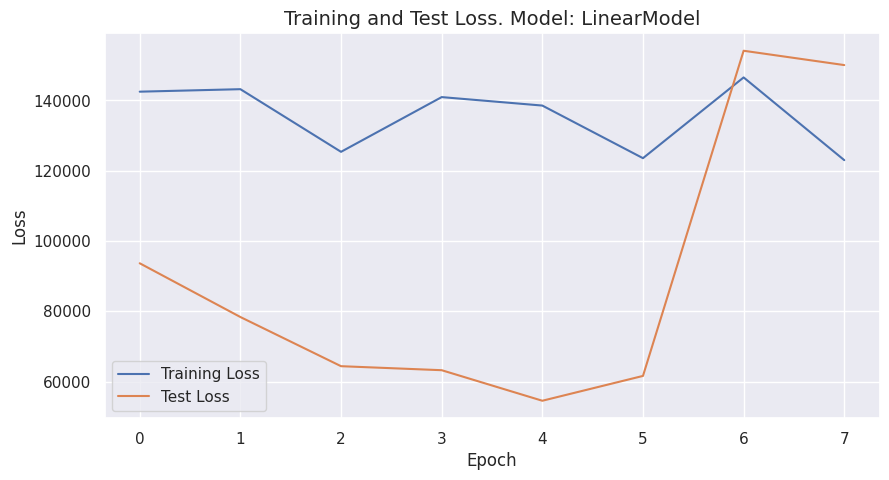

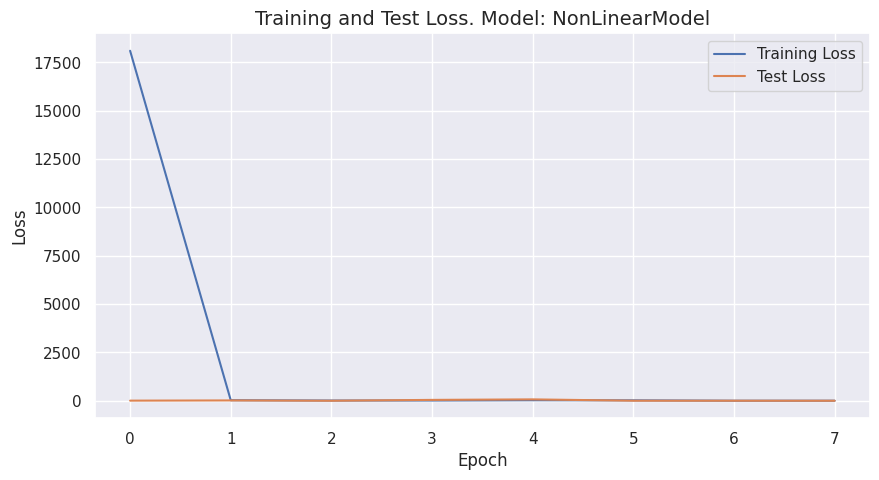

In [31]:
plot_losses(train_loss_models['LinearModel'], val_loss_models['LinearModel'], model_name = 'LinearModel', ylim=None)
plot_losses(train_loss_models['NonLinearModel'], val_loss_models['NonLinearModel'], model_name = 'NonLinearModel', ylim=None)


### Spearman rank coefficient

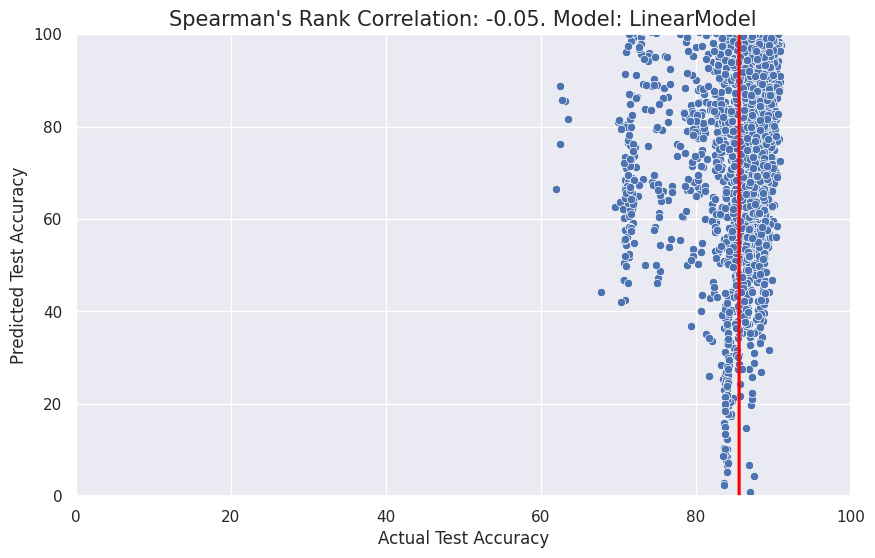

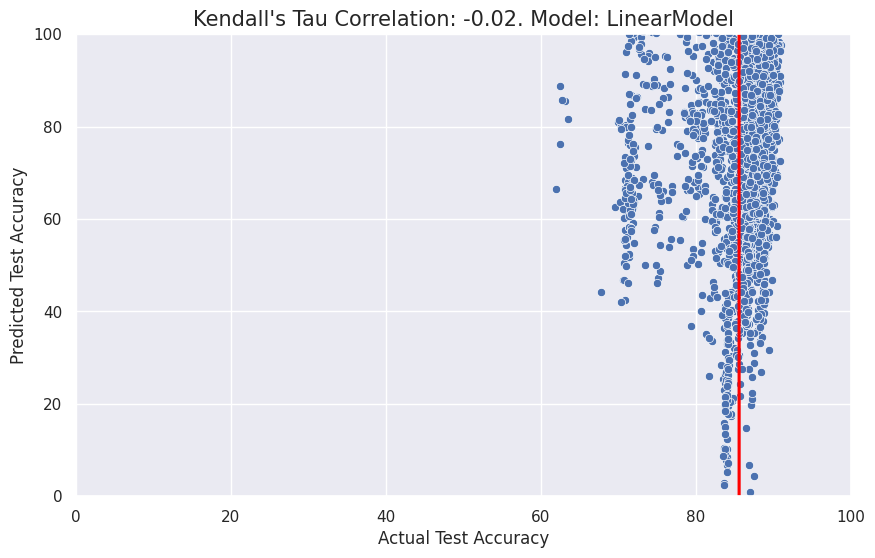

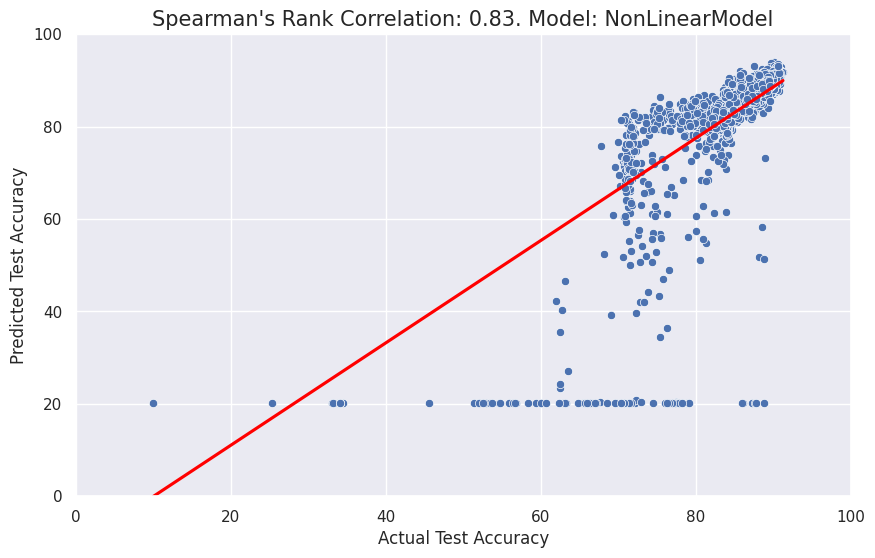

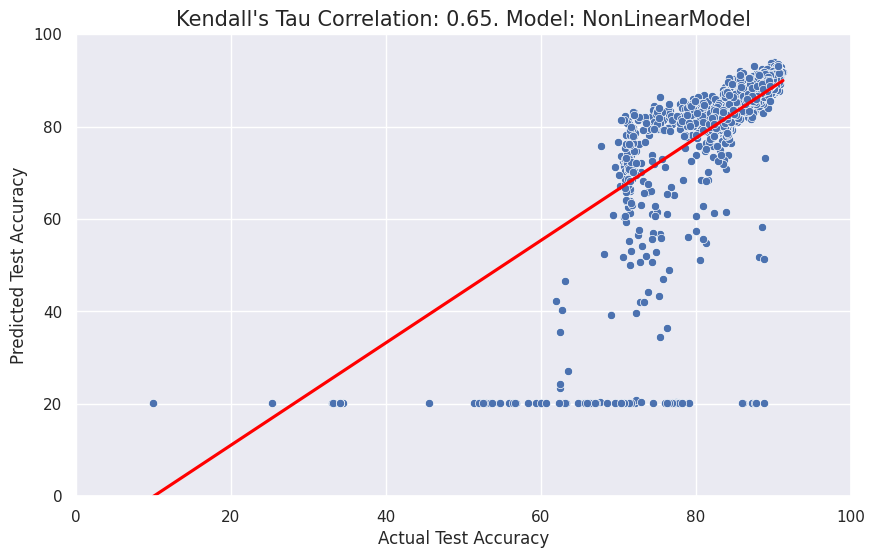

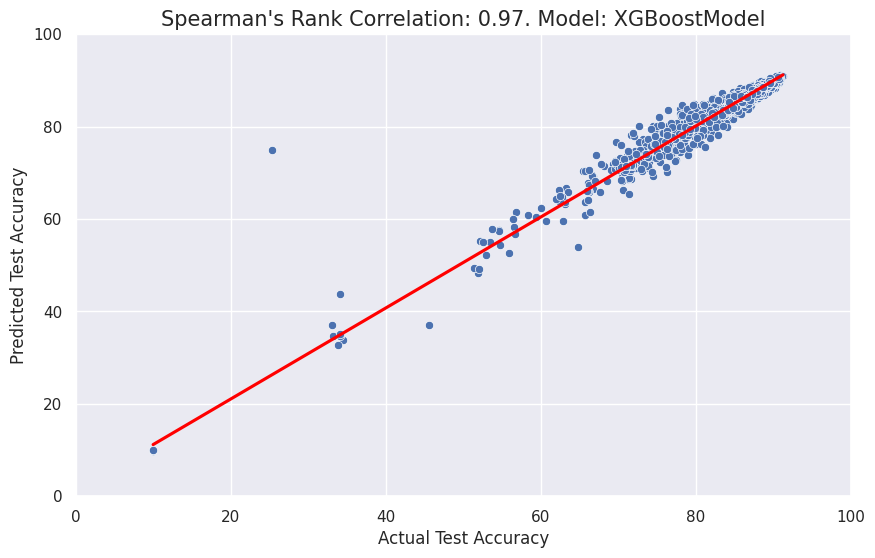

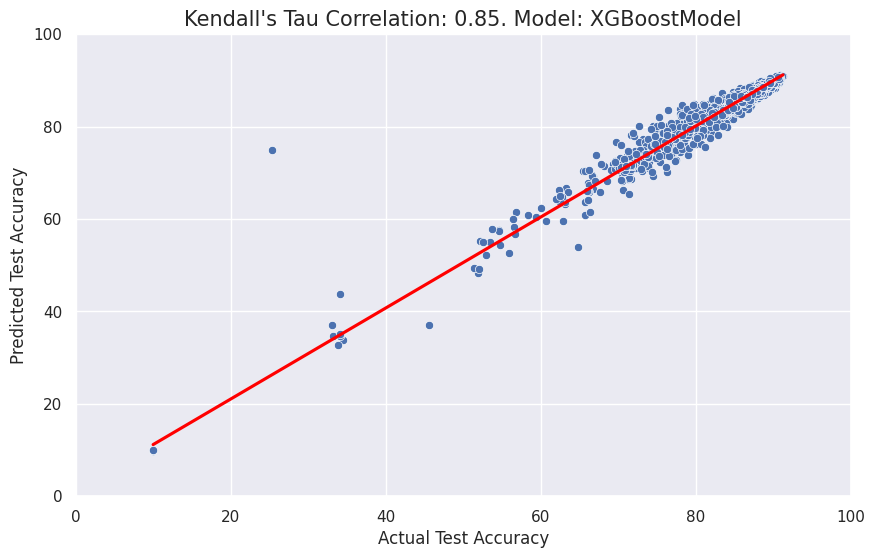

In [32]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

plot_model_correlations(linearModel, test_loader, model_name = 'LinearModel')

plot_model_correlations(nonLinearModel, test_loader, model_name = 'NonLinearModel')

plot_model_correlations(xgboost_model, test_loader, model_name = 'XGBoostModel')

### Hyperparameter Tuner

Dynamic network model for tuner 

In [33]:
class DynamicModel(nn.Module):
    def __init__(self, input_size, num_layers, hidden_units, output_size):
        super(DynamicModel, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            in_features = input_size if i == 0 else hidden_units
            self.layers.append(nn.Linear(in_features, hidden_units))
        self.final = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        return self.final(x)

Hyperparameter Objective Function

In [34]:
train_dataset = CustomDataset(inputs_train, targets_train, use_percentage = .1)
val_dataset = CustomDataset(inputs_val, targets_val, use_percentage = 1)
test_dataset = CustomDataset(inputs_test, targets_test, use_percentage = 1)

In [35]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_units = trial.suggest_int('hidden_units', 5, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop'])
    loss_function = trial.suggest_categorical('loss_function', ['L1', 'MSE', 'SmoothL1'])

    model = DynamicModel(13, num_layers, hidden_units, 1)
    optimizer = {"Adam": optim.Adam, "RMSprop": optim.RMSprop}[optimizer_name](model.parameters(), lr=lr)
    criterion = {"L1": nn.L1Loss(), "MSE": nn.MSELoss(), "SmoothL1": nn.SmoothL1Loss()}[loss_function]

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model.train()
    for epoch in range(20):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    model.eval()
    criterion2 = nn.L1Loss()
    total_loss = 0.0
    n_samples = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion2(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            n_samples += inputs.size(0)
    avg_loss = total_loss / n_samples

    # Here, save the best model state dict to the trial
    trial.set_user_attr('best_model_state', model.state_dict())

    return avg_loss

Optuna Study

In [36]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Save the best model fully, not just state_dict, after optimization
best_model_state = study.best_trial.user_attrs['best_model_state']
model = DynamicModel(13, study.best_trial.params['num_layers'], study.best_trial.params['hidden_units'], 1)
model.load_state_dict(best_model_state)

# Save the complete model
torch.save(model, 'saved_models/best_complete_model.pth')

# Load the complete model for prediction or further training
loaded_model = torch.load('saved_models/best_complete_model.pth')

print('Best trial (minimizing selected loss function):')
print(f'Value (Loss): {study.best_trial.value}')
print('Params: ')
for key, value in study.best_trial.params.items():
    print(f'{key}: {value}')


[I 2024-03-17 15:39:33,512] A new study created in memory with name: no-name-a9668d40-d8a7-4f7d-ab6e-186ff025d8a1
/tmp/ipykernel_66451/2544609758.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2024-03-17 15:39:44,784] Trial 0 finished with value: 1265.8913671569824 and parameters: {'lr': 0.00012618703521844927, 'batch_size': 2, 'num_layers': 3, 'hidden_units': 29, 'optimizer': 'RMSprop', 'loss_function': 'SmoothL1'}. Best is trial 0 with value: 1265.8913671569824.
[I 2024-03-17 15:40:03,213] Trial 1 finished with value: 68.54557558349609 and parameters: {'lr': 0.012301802159790242, 'batch_size': 1, 'num_layers': 1, 'hidden_units': 43, 'optimizer': 'Adam', 'loss_function': 'MSE'}. Best is trial 1 with value: 68.54557558349609.
[I 2024-03-17 15:40:06,653] Trial 2 finished wi

Best trial (minimizing selected loss function):
Value (Loss): 2.7455622791290284
Params: 
lr: 0.0025745256338942355
batch_size: 8
num_layers: 3
hidden_units: 13
optimizer: Adam
loss_function: SmoothL1


Predicting and Plotting the Result

This is on the tuned results where it is trained on dataset its tested on

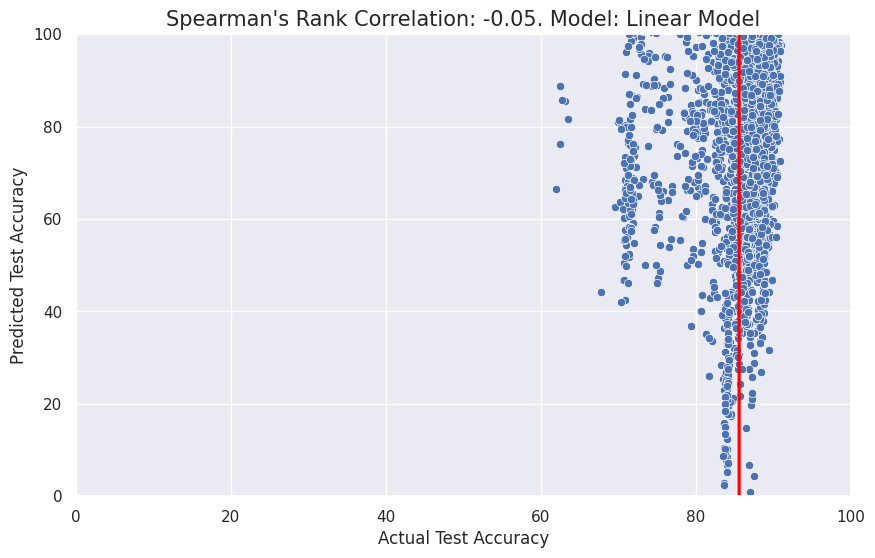

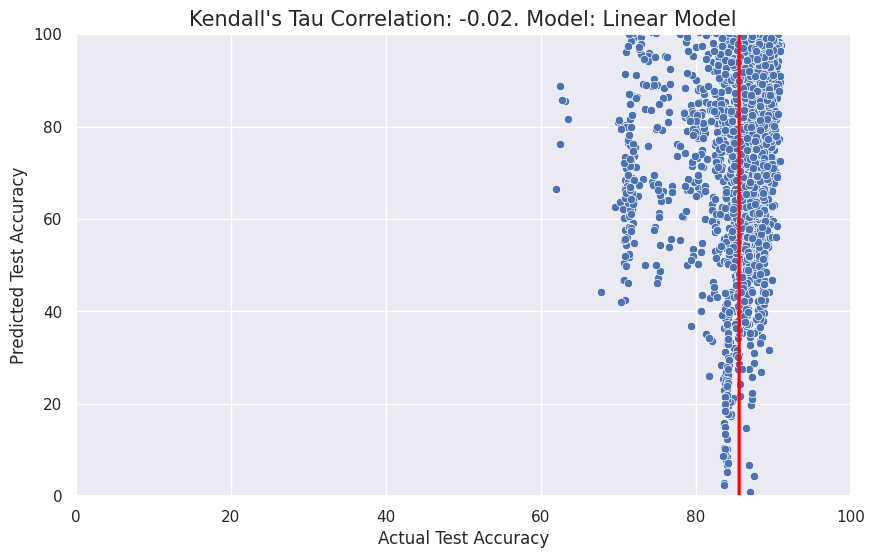

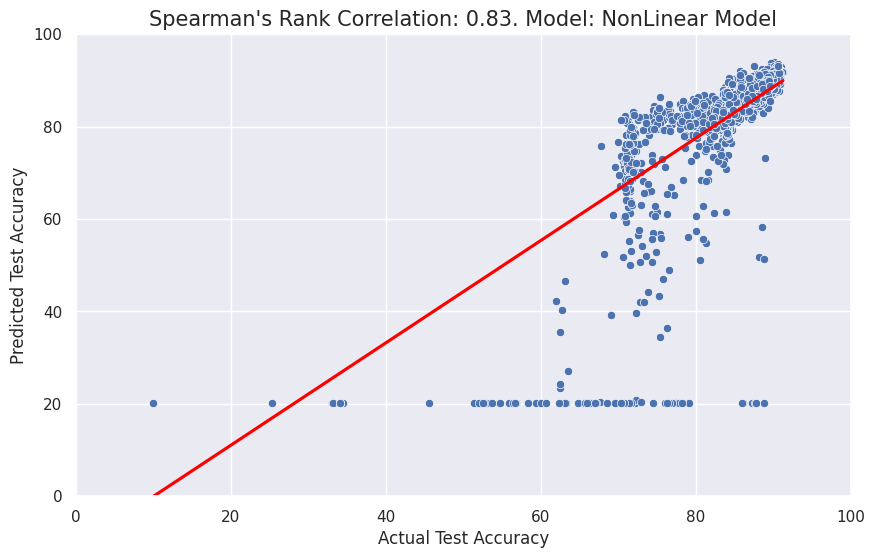

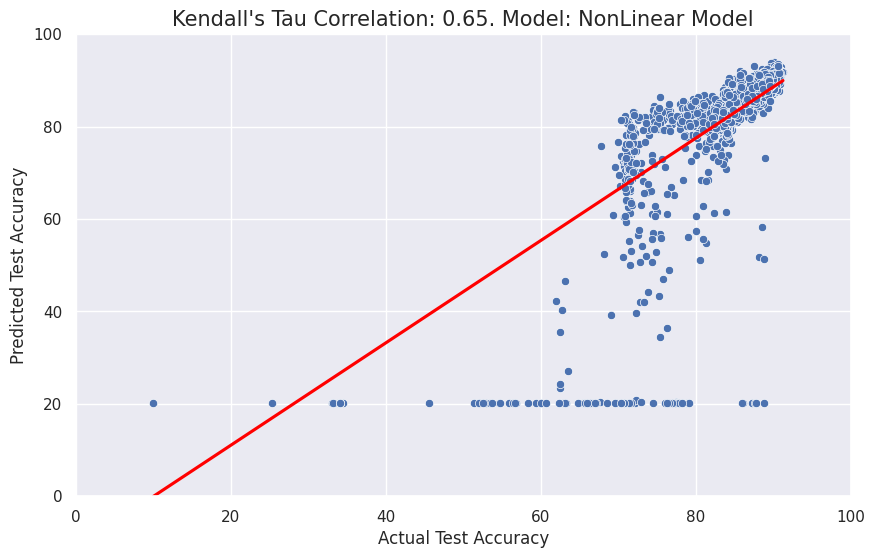

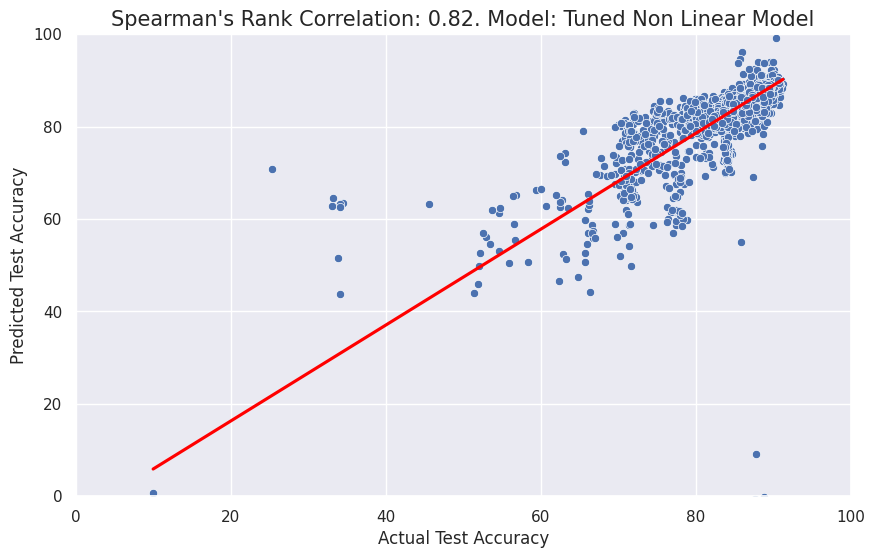

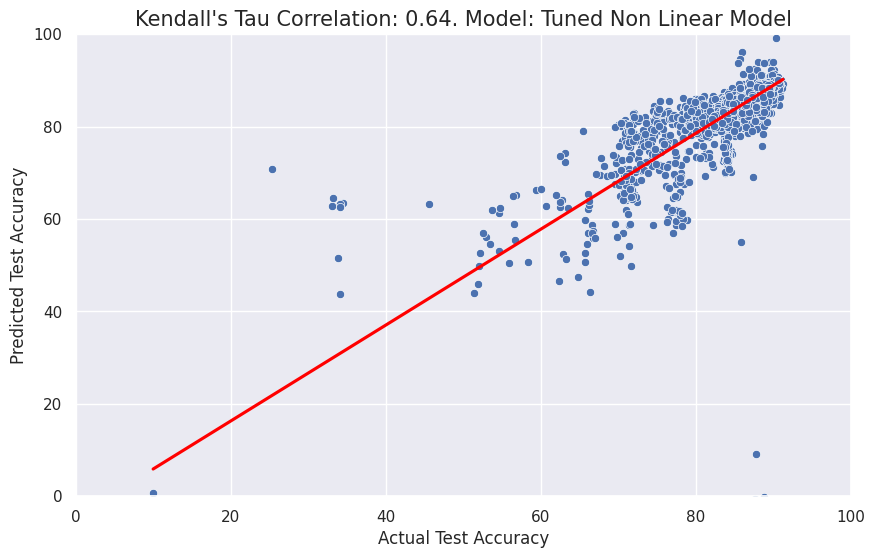

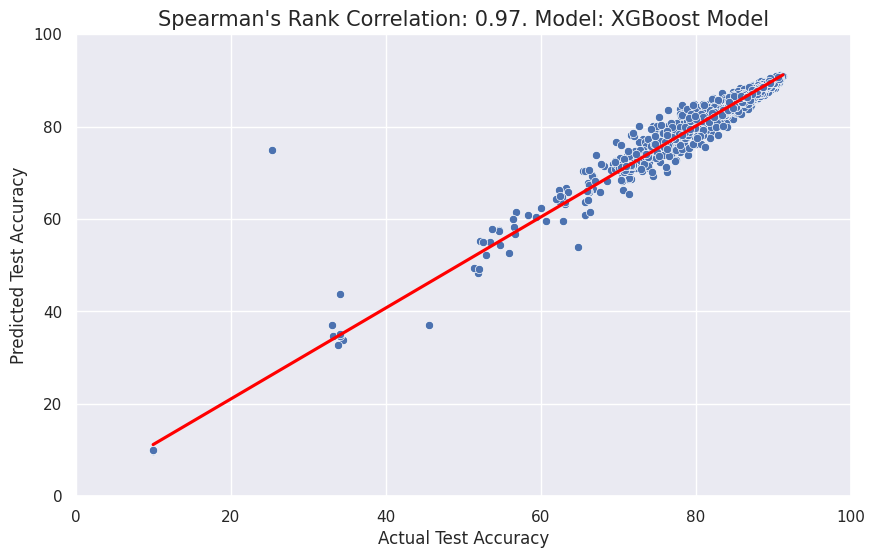

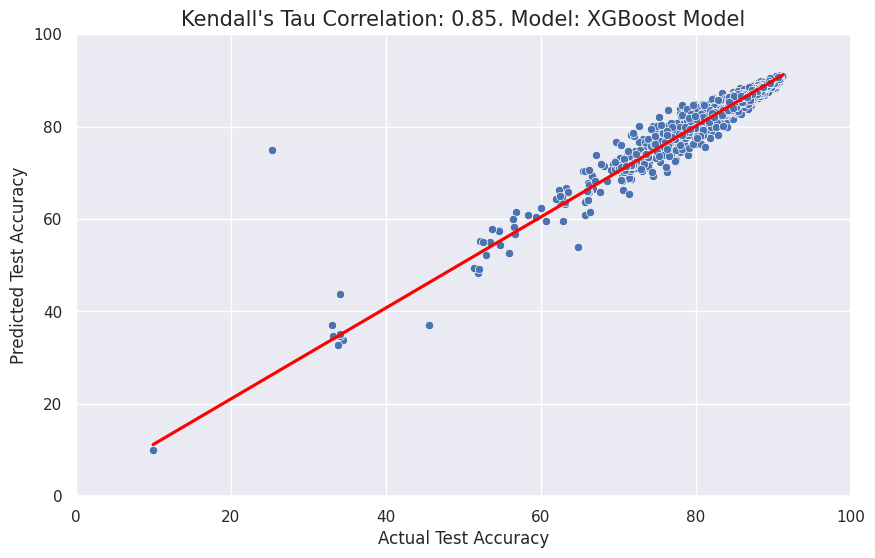

In [37]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

plot_model_correlations(linearModel, test_loader, model_name = 'Linear Model')

plot_model_correlations(nonLinearModel, test_loader, model_name = 'NonLinear Model')

plot_model_correlations(loaded_model, test_loader, model_name = 'Tuned Non Linear Model')

plot_model_correlations(xgboost_model, test_loader, model_name = 'XGBoost Model')


## Evaluation on model transfer to other datasets

If network is trained on CIFAR10 how well do the models to transfer to CIFAR100 without retraining

In [38]:
file = '/home/laurie2905/mase_ADL/mase/NASLib/naslib/data/zc_nasbench201.json'
with open(file, 'r') as f:
    data = json.load(f)
    data = data['cifar100']


targets = [data[arch]['val_accuracy'] for arch in data.keys()]
inputs = []

for arch in data.keys():

    inputs.append([data[arch].get(metric_name, 0)['score'] for metric_name in ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot','plain','snip','synflow','zen','flops','params'] ])
    

/tmp/ipykernel_66451/1449276215.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/tmp/ipykernel_66451/1449276215.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32).view(-1, 1)


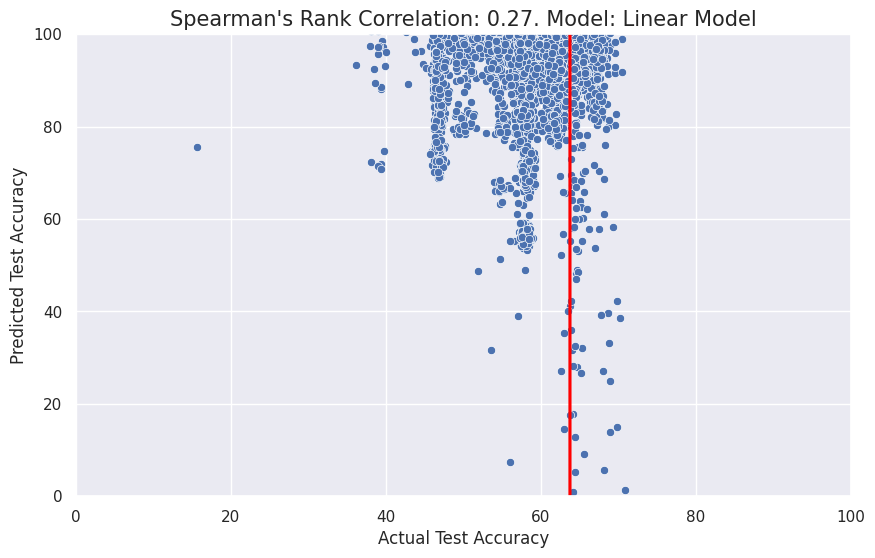

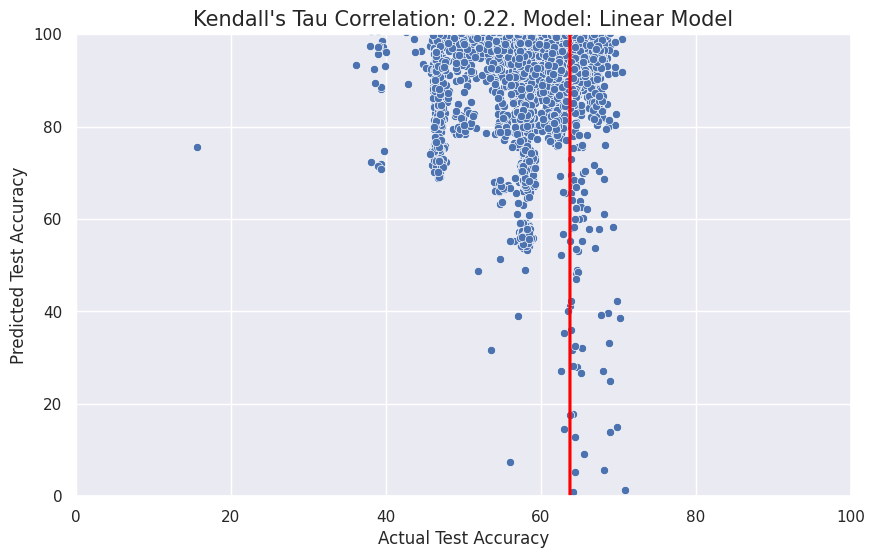

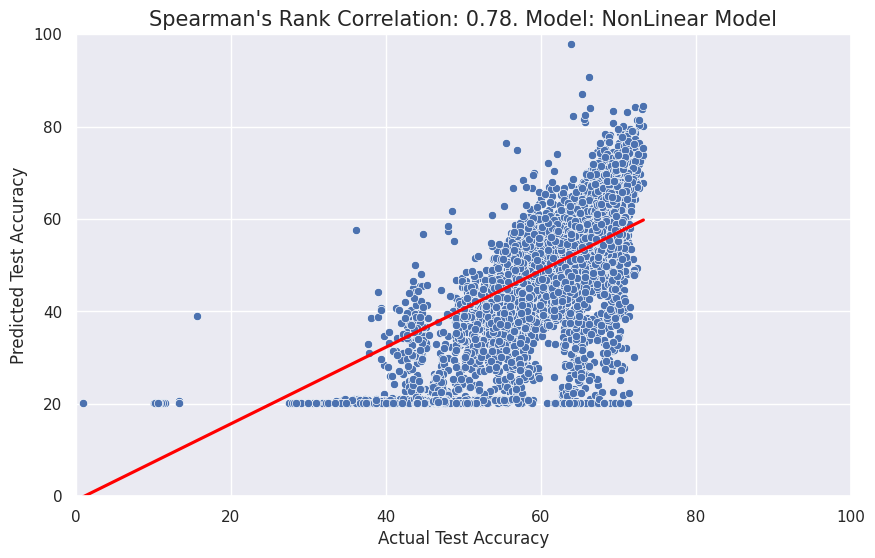

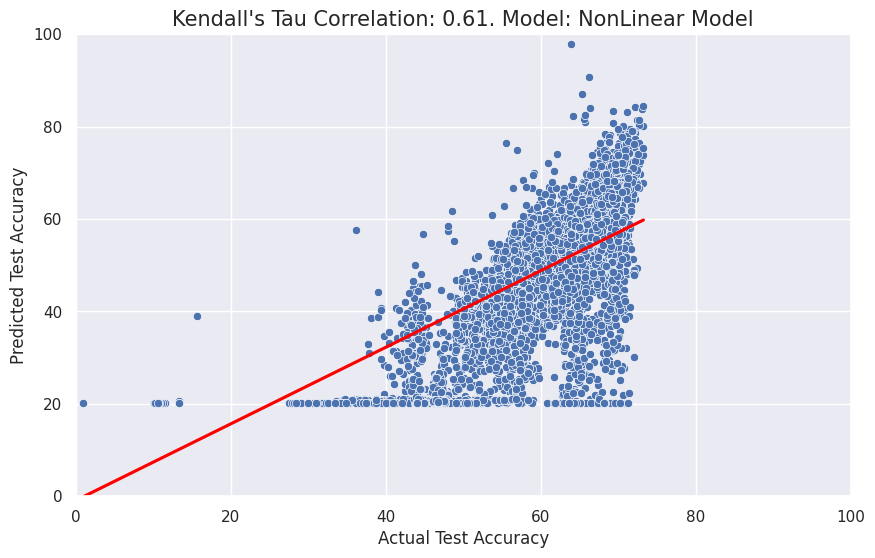

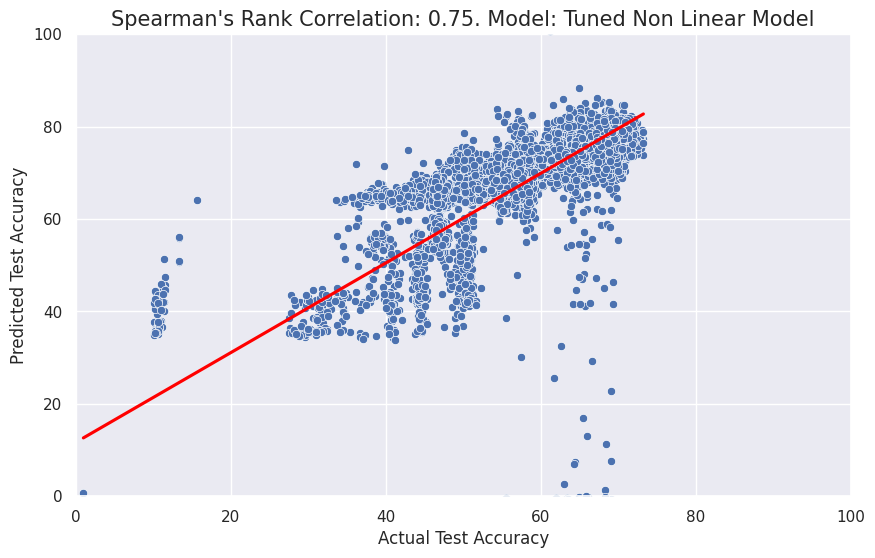

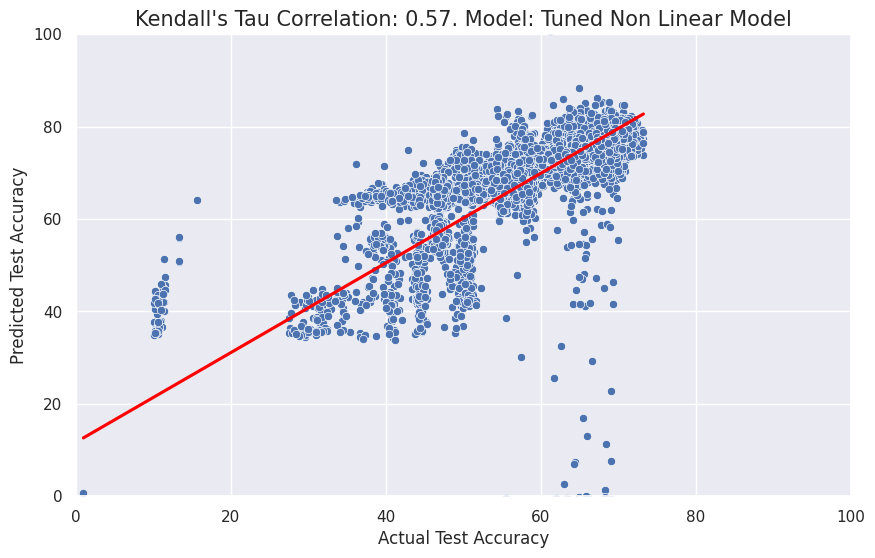

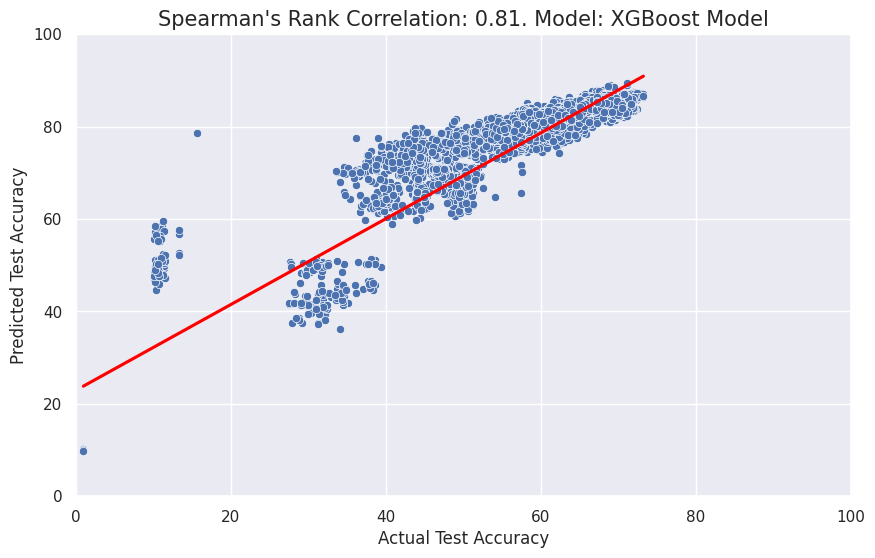

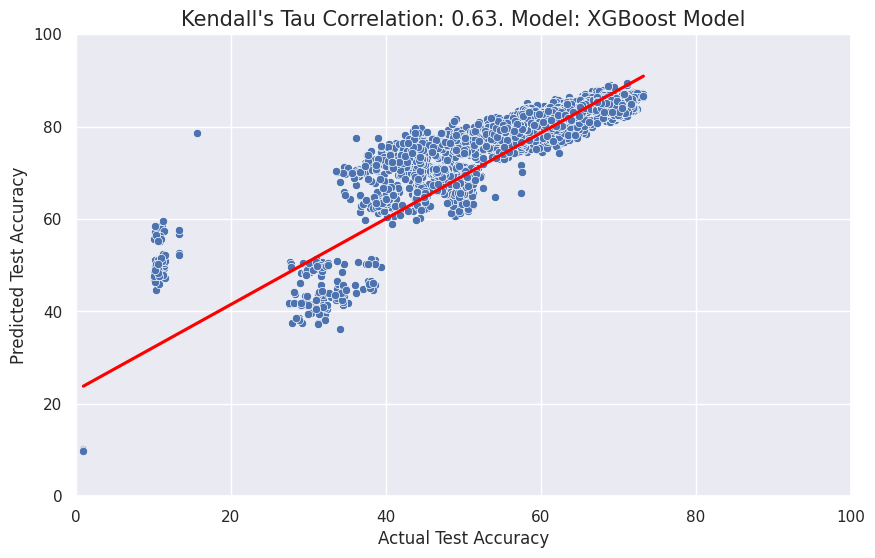

In [40]:
# Convert lists to PyTorch tensors
inputs = torch.tensor(inputs, dtype=torch.float32)

targets = torch.tensor(targets, dtype=torch.float32).view(-1, 1)

test_dataset = CustomDataset(inputs, targets, use_percentage = 1)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

plot_model_correlations(linearModel, test_loader, model_name = 'Linear Model')

plot_model_correlations(nonLinearModel, test_loader, model_name = 'NonLinear Model')

plot_model_correlations(loaded_model, test_loader, model_name = 'Tuned Non Linear Model')

plot_model_correlations(xgboost_model, test_loader, model_name = 'XGBoost Model')